# Homework 5 - Text Mining Shakespeare

The goal of this project is to generate new text from various Shakespeare plays. We use Recurrent Neural Networks (RNNs) to do so. To assess the quality of our model, we compare the generated text to Shakespeare's originals.

In [1]:
# All imports
import tensorflow as tf
import os.path
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from functools import reduce
import matplotlib.pyplot as plt
import sklearn.metrics

from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Embedding, LSTM, Dense, Conv1D, Dropout, Activation
import keras

import random
import sys

%matplotlib inline

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data

The data comes from Project Gutenberg. We downloaded the following books manually from the [Gutenberg website](https://www.gutenberg.org/ebooks/search/?query=shakespeare):

Title | ID
------|----
Romeo and Juliet | 1112
Hamlet | 1524
Macbeth | 2264
Midsummer Night's Dream| 2242
The Tempest | 23042
Othello | 2267
The Tragedy Of Julius Caesar | 1120
The Tragedy Of King Lear | 1128
Twelth Night; Or, What You Will | 1526
As You Like It | 1121
The Taming Of The Shrew | 1107
Henry V | 2253
King Richard III | 1103

The raw text files are stored in the subfolder `./data` of this project. We first write a helper class to read a single text, encode the text as an integer array and translate an integer array back to text.

In [2]:
# Encode in dictionary
text_to_id = {
'Romeo and Juliet': '1112',
'Hamlet': '1524',
'Macbeth': '2264',
"Midsummer Night's Dream": "2242",
"The Tempest": "23042",
"Othello": "2267",
"The Tragedy Of Julius Caesar": "1120",
"The Tragedy Of King Lear": "1128",
"Twelth Night; Or, What You Will": "1526",
"As You Like It": "1121",
"The Taming Of The Shrew": "1107",
"Henry V": "2253",
"King Richard III": "1103"}

id_to_text = {value: key for key, value in text_to_id.items()}

In [3]:
class shakespeare_text():
    """
    Contains all data and methods for a given Shakespeare text.
    """
    def __init__(self, id):
        #Contains entire text of book
        self.text = self.__read_text_(id)
        
        self.text_length = len(self.text)
        #Characters in book
        self.vocab = sorted(set(self.text))
        #Dictionary of character to index mapping
        self.vocab_to_int = {c: i for i, c in enumerate(self.vocab)}
        #Total characters in book
        self.vocab_length = len(self.vocab)
        #Dictionary of index to character mapping
        self.int_to_vocab = dict(enumerate(self.vocab))
        #Characters in text mapped to indexes as numpy array
        self.array = np.array([self.vocab_to_int[c] for c in self.text], dtype=np.int32)
        #store batch size to object instance
        self.batch_size = 40
        self.step_size = 3


    def __read_text_(self, id):
        """
        Reads text corresponding to one of the ids.

        :param id: string
        """
        text_path = os.path.join('data', 'pg' + id + '.txt')
        with open(text_path) as file:
            txt = file.read()
            
        #Contains starting index of text for each book
        #Used to remove copyright information from the text
        pos_dict = {  '1112':[1799,159841],
                      '1524':[11818,192814],
                      '2264':[16241,119813],
                      '2242':[15880,112106],
                     '23042':[2230,142976],
                      '2267':[15926,171448],
                      '1120':[9030,140961],
                      '1128':[9033,185348],
                      '1526':[11920,131682],
                      '1121':[2360,142514],
                      '1107':[9030,148671],
                      '2253':[11860,170304],
                      '1103':[1950,200275] }
        
        return txt[pos_dict[id][0]:pos_dict[id][1]]
    
    def batches_gen(self, batch_size, seq_size):
        """
        Batch generator that returns batches of size
        batch_size x seq_size from array.

        :param batch_size: Batch size, the number of sequences per batch
        :seq_size: Number of characters per sequence.
        """
        # Get the number of characters per batch and number of batches we can make
        characters_per_batch = batch_size * seq_size
        n_batches = len(self.array) // characters_per_batch

        # Keep only enough characters to make full batches
        arr = self.array[:characters_per_batch * n_batches]

        # Reshape into n_seqs rows
        arr = arr.reshape((batch_size, -1))

        for n in range(0, arr.shape[1], seq_size):
            # The features
            x = arr[:, n:(n+characters_per_batch)]
            # The targets, shifted by one
            y = np.zeros_like(x)
            y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
            yield x, y
            
    def int_to_text(self, array):
        """
        Converts an integer array to the corresponding text.
        
        :param array: numpy array of integers with values in the vocabulary
        """
        int_list = array.tolist()
        char_list = map(lambda x: self.int_to_vocab[x], int_list)
        text = reduce(lambda x, y: x + y, char_list)
        return text
    
    def print(self):
        print(self.text)

In [4]:
romeo_juliet = shakespeare_text('1112')

# Train generator

Now we can use the class written above to read in the Shakespeare plays. Then, for each play we train a separate RNN and use it to generate new text.

For reusability, the script is split into a train and generate function. We will save the model from the train function.

In [ ]:

def train(id,obj,iterations=80):
    sentences = []
    next_chars = []
    for i in range(0, obj.text_length - obj.batch_size, obj.step_size):
        sentences.append(obj.text[i: i + obj.batch_size])
        next_chars.append(obj.text[i + obj.batch_size])

    #One hot encode 
    x = np.zeros((len(sentences),obj.batch_size, obj.vocab_length), dtype=np.bool)
    y = np.zeros((len(sentences), obj.vocab_length), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, obj.vocab_to_int[char]] = 1
            y[i, obj.vocab_to_int[next_chars[i]]] = 1
    
    #Define the LSTM model
    #Long-Short Term Memory layer - Hochreiter 1997 with tanh activation function
    model = Sequential()
    model.add(LSTM(128, input_shape=(obj.batch_size, obj.vocab_length)))
    model.add(Dense(obj.vocab_length))
    model.add(Activation('softmax'))
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    
    # train the model
    for iteration in range(1, iterations):
        print()
        print('-' * 50)
        print('Iteration', iteration)
        model.fit(x, y,
                  batch_size=128,
                  epochs=1)
    
    #Save model for future use
    model.save('model_' + id + '.h5') 
    return model
    


## Generate text

The generate function starts at a random position in the text and uses it as a "seed". We then create 4 different sequences from different multinomial sampling distributions. Each generated sequence is 2000 characters long.

In [ ]:
def generate(id,obj,model):

    def sample(preds, temperature=1.0):
        # helper function to sample an index from a probability array
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        return np.argmax(probas)
    
    start_index = random.randint(0, obj.text_length - obj.batch_size - 1)
    gen_text = ''
    
    # generate 4 sequences of 2000 characters 
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        generated = ''
        sentence = obj.text[start_index: start_index + obj.batch_size]
        generated += sentence
              
        for i in range(2000):
            x_pred = np.zeros((1, obj.batch_size, obj.vocab_length))
            for t, char in enumerate(sentence):
                x_pred[0, t, obj.vocab_to_int[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = obj.int_to_vocab[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
            
        gen_text+=('\n'+generated)
    return gen_text

Finally we will write the generated text to an external file for testing. The files we generated were trained for 80 epochs till we obtained logloss of around .6. We found that around 40 epochs we started seeing identifiable word structure. 

In [ ]:
def write_shakespeare(id):
    #instantiate object to pass to subsequent functions
    shakespeare = shakespeare_text(id)
    
    #Setting to only one iteration for the final compilation
    #Actual predictions were performed on 80 epochs
    #trm contains the trained model. To perform in batch use load_model
    trm = train(id,shakespeare,iterations=2)
    
    #Write generated text to external file
    print(generate(id,shakespeare,trm), file=open("./gen_data/gen_"+ id +".txt", "w"))



write_shakespeare('1112')
write_shakespeare('1524')
write_shakespeare('2264')
write_shakespeare('2242')
write_shakespeare('23042')
write_shakespeare('2267')
write_shakespeare('1120')
write_shakespeare('1128')
write_shakespeare('1526')
write_shakespeare('1121')
write_shakespeare('1107')
write_shakespeare('2253')
write_shakespeare('1103')

## Generated text example

Here is a short excerpt of generated from Julius Ceasar:

>Exit Brutus.

>    I dvey, ware you all your hands and stinn.

>  CASSIUS. Most noble be some stay athy leess. 

    >    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I had rey bears at a seeator and foan

    >    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To what thou somens.

>  BRUTUS. I comes to but our hands and that I do not day

    >    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Oven men are and yet he was ambitious, Brutus.

    >    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Stale you is come to you, if words if Malker Cassius worse.

> --<cite>Tarap_Noll, Julius Ceaser</cite>


We can see from this excerpt that basic sentence structure has been "learnt":  Sentences start with capital letters and end with full stops. Additionally, the LSTM has managed to identify characters and that their dialogue should begin with capatilized names. 

We can also, however, see that the model does not handle context well. In this scene Brutus has exited before delivering his line.
Brutus also appears to be talking to himself in this scene.

So, although far from perfect, our generator does generate somewhat passable Shakespeare to the human eye, provided that you dont look to deep.

 

# Train discriminator

We use an RNN to discriminate between the Shakespeare plays. The goal is to have a classification model based on sequences of text with the target variables corresponding to the different plays.

## Data preparation

We start by describing the data preparation:

First, we read in all texts using the class defined above.

In [5]:
ids = ['1112', '1524', '2264', '2242', '23042', '2267', '1120', '1128', '1526', '1121', '1107', '2253', '1103']
all_texts = {x: shakespeare_text(x) for x in ids}

Since our goal is to build a model to discriminate the different Shakespeare plays, we need the plays as target variables. Suitable target variables need to be one hot encoded. In order to achieve that we fit a `LabelBinarizer` on the ids:

In [6]:
# Build the label binarizer
encoder = LabelBinarizer()
encoder.fit(ids)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

Next, we extract a vocabulary of all characters used in all Shakespeare plays that we look at.

In [7]:
vocab = sorted(set(reduce(lambda x, y: x + y, [all_texts[text_id].text for text_id in ids])))
vocab_to_int = {c: i for i, c in enumerate(vocab)}

Finally, we write the batch generator. It consists of the following steps:

1. Sample a play.
2. Sample a starting point in the play. Depending on the input variable `train_cv` these are either the last 10% of the text or the first 90%.
3. Get sequences of length `seq_size` starting at the starting point sampled before.
4. Stack all sequences.

In [8]:
def batch_gen(batch_size, seq_size, train_cv='train'):
    """
    Batch generator for the discriminator.
    
    :param batch_size: number of batches
    :param seq_size: number of characters per sequence
    :param train_cv: indicates whether we use the batch generator for training or cross validation
    """
    while True:
        # Get texts at random
        sampled_ids = np.random.choice(ids, size=batch_size, replace=True)
        sampled_labels = encoder.transform(sampled_ids)

        # Get random starting points from each text
        text_lens = list(map(lambda x: len(all_texts[x].text), sampled_ids))
        if train_cv == 'train':
            start_indices = list(map(lambda x: np.random.choice(int(x * 0.9)), text_lens))
        elif train_cv == 'cv':
            start_indices = list(map(lambda x: np.random.choice(int(x * 0.1)) + int(x * 0.9) - seq_size, text_lens))

        # Generate random text sequences
        sequences = []
        for text_id, start_ind in zip(sampled_ids, start_indices):
            text_sequence = all_texts[text_id].text[start_ind:(start_ind+seq_size)]
            int_sequence = [vocab_to_int[s] for s in text_sequence]
            sequences.append(int_sequence)

        # Return
        yield np.array(sequences), np.array(sampled_labels)

## Build the discriminator model

Next, we start building the discriminator model. All of this is done using the Keras API:

In [9]:
batch_size = 10
seq_len = 200

In [9]:
from keras.layers import Embedding, LSTM, Dense, Conv1D, Dropout
from keras.models import Sequential
import keras
keras.callbacks.History()
callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model = Sequential()
model.add(Embedding(len(vocab), 32, input_length=seq_len))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
#model.add(LSTM(60, return_sequences=True))
model.add(LSTM(40))
model.add(Dropout(rate=0.25))
model.add(Dense(len(ids), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


In [10]:
model.fit_generator(batch_gen(batch_size, seq_len),
                    steps_per_epoch=100, 
                    epochs=600,
                    validation_data=batch_gen(batch_size, seq_len, train_cv='cv'), 
                    validation_steps=100,
                    callbacks=[callback])

model.save('discriminator.h5')

Epoch 1/600
100/100 [==============================] - 13s 126ms/step - loss: 2.5646 - acc: 0.0800 - val_loss: 2.5657 - val_acc: 0.0810
Epoch 2/600
100/100 [==============================] - 13s 126ms/step - loss: 2.5635 - acc: 0.0790 - val_loss: 2.5613 - val_acc: 0.0770
Epoch 3/600
100/100 [==============================] - 13s 126ms/step - loss: 2.5066 - acc: 0.1110 - val_loss: 2.5829 - val_acc: 0.1080
Epoch 4/600
100/100 [==============================] - 13s 126ms/step - loss: 2.5315 - acc: 0.1240 - val_loss: 2.5298 - val_acc: 0.0840
Epoch 5/600
100/100 [==============================] - 12s 125ms/step - loss: 2.3429 - acc: 0.1400 - val_loss: 2.4256 - val_acc: 0.1450
Epoch 6/600
100/100 [==============================] - 13s 125ms/step - loss: 2.4542 - acc: 0.1790 - val_loss: 3.0311 - val_acc: 0.0620
Epoch 7/600
100/100 [==============================] - 12s 123ms/step - loss: 2.5700 - acc: 0.1490 - val_loss: 2.5388 - val_acc: 0.1170
Epoch 8/600
100/100 [===========================

Epoch 61/600
100/100 [==============================] - 12s 120ms/step - loss: 1.7592 - acc: 0.2560 - val_loss: 3.1809 - val_acc: 0.1490
Epoch 62/600
100/100 [==============================] - 12s 119ms/step - loss: 1.7351 - acc: 0.2440 - val_loss: 3.0355 - val_acc: 0.1310
Epoch 63/600
100/100 [==============================] - 12s 120ms/step - loss: 1.7405 - acc: 0.2460 - val_loss: 2.9572 - val_acc: 0.1170
Epoch 64/600
100/100 [==============================] - 12s 120ms/step - loss: 1.7490 - acc: 0.2190 - val_loss: 2.8963 - val_acc: 0.1790
Epoch 65/600
100/100 [==============================] - 12s 119ms/step - loss: 1.7785 - acc: 0.2320 - val_loss: 2.7792 - val_acc: 0.1110
Epoch 66/600
100/100 [==============================] - 12s 119ms/step - loss: 1.7356 - acc: 0.2500 - val_loss: 2.8488 - val_acc: 0.12400s - loss: 1.7333 - acc
Epoch 67/600
100/100 [==============================] - 12s 119ms/step - loss: 1.7270 - acc: 0.2460 - val_loss: 2.8498 - val_acc: 0.1240
Epoch 68/600
100/1

100/100 [==============================] - 12s 119ms/step - loss: 1.0830 - acc: 0.5250 - val_loss: 2.3090 - val_acc: 0.3150
Epoch 180/600
100/100 [==============================] - 12s 120ms/step - loss: 1.0121 - acc: 0.5580 - val_loss: 2.4127 - val_acc: 0.3510
Epoch 181/600
100/100 [==============================] - 12s 120ms/step - loss: 1.0617 - acc: 0.5300 - val_loss: 2.4397 - val_acc: 0.3190
Epoch 182/600
100/100 [==============================] - 12s 119ms/step - loss: 1.0927 - acc: 0.5030 - val_loss: 2.5894 - val_acc: 0.2670
Epoch 183/600
100/100 [==============================] - 12s 120ms/step - loss: 1.0718 - acc: 0.5400 - val_loss: 2.4379 - val_acc: 0.3670
Epoch 184/600
100/100 [==============================] - 12s 120ms/step - loss: 1.0479 - acc: 0.5320 - val_loss: 2.3376 - val_acc: 0.3410
Epoch 185/600
100/100 [==============================] - 12s 119ms/step - loss: 1.0532 - acc: 0.5400 - val_loss: 2.7566 - val_acc: 0.2890
Epoch 186/600
100/100 [=========================

100/100 [==============================] - 12s 120ms/step - loss: 0.7212 - acc: 0.7160 - val_loss: 1.9636 - val_acc: 0.5320
Epoch 298/600
100/100 [==============================] - 12s 120ms/step - loss: 0.7218 - acc: 0.7040 - val_loss: 1.8539 - val_acc: 0.5380
Epoch 299/600
100/100 [==============================] - 12s 120ms/step - loss: 0.8004 - acc: 0.6800 - val_loss: 1.9688 - val_acc: 0.5040
Epoch 300/600
100/100 [==============================] - 12s 120ms/step - loss: 0.7067 - acc: 0.7100 - val_loss: 1.9417 - val_acc: 0.5180
Epoch 301/600
100/100 [==============================] - 12s 120ms/step - loss: 0.6730 - acc: 0.7340 - val_loss: 1.9165 - val_acc: 0.5140
Epoch 302/600
100/100 [==============================] - 12s 120ms/step - loss: 0.6894 - acc: 0.7290 - val_loss: 2.1261 - val_acc: 0.4810
Epoch 303/600
100/100 [==============================] - 12s 119ms/step - loss: 0.6838 - acc: 0.7280 - val_loss: 2.0876 - val_acc: 0.5050
Epoch 304/600
100/100 [=========================

100/100 [==============================] - 12s 119ms/step - loss: 0.4683 - acc: 0.8210 - val_loss: 1.9877 - val_acc: 0.5710
Epoch 416/600
100/100 [==============================] - 12s 119ms/step - loss: 0.4921 - acc: 0.8130 - val_loss: 2.0309 - val_acc: 0.5440
Epoch 417/600
100/100 [==============================] - 12s 120ms/step - loss: 0.4941 - acc: 0.8090 - val_loss: 1.9491 - val_acc: 0.5800
Epoch 418/600
100/100 [==============================] - 12s 120ms/step - loss: 0.5270 - acc: 0.8050 - val_loss: 1.9596 - val_acc: 0.5790
Epoch 419/600
100/100 [==============================] - 12s 119ms/step - loss: 0.4946 - acc: 0.8240 - val_loss: 2.0623 - val_acc: 0.5620
Epoch 420/600
100/100 [==============================] - 12s 120ms/step - loss: 0.4558 - acc: 0.8260 - val_loss: 1.9782 - val_acc: 0.5830
Epoch 421/600
100/100 [==============================] - 12s 120ms/step - loss: 0.4686 - acc: 0.8180 - val_loss: 2.1347 - val_acc: 0.5670
Epoch 422/600
100/100 [=========================

100/100 [==============================] - 12s 119ms/step - loss: 0.3856 - acc: 0.8640 - val_loss: 2.1124 - val_acc: 0.5660
Epoch 534/600
100/100 [==============================] - 12s 119ms/step - loss: 0.4123 - acc: 0.8300 - val_loss: 2.0230 - val_acc: 0.5820
Epoch 535/600
100/100 [==============================] - 12s 119ms/step - loss: 0.4000 - acc: 0.8430 - val_loss: 2.1642 - val_acc: 0.5500
Epoch 536/600
100/100 [==============================] - 12s 119ms/step - loss: 0.3725 - acc: 0.8490 - val_loss: 2.1633 - val_acc: 0.5590
Epoch 537/600
100/100 [==============================] - 12s 119ms/step - loss: 0.4044 - acc: 0.8610 - val_loss: 2.0990 - val_acc: 0.5890
Epoch 538/600
100/100 [==============================] - 12s 119ms/step - loss: 0.3792 - acc: 0.8630 - val_loss: 2.0670 - val_acc: 0.5730
Epoch 539/600
100/100 [==============================] - 12s 118ms/step - loss: 0.3948 - acc: 0.8560 - val_loss: 2.5553 - val_acc: 0.5580
Epoch 540/600
100/100 [=========================

# Evaluation of generated text

## Evaluation with discriminator

Next, we can use the trained discriminator to evaluate the generated text. If our text generation model is good, it should achieve accuracy similar to the accuracy in the original plays. It should not work better or worse. 

## Original data

We also show the confusion matrix. This should also be similar to the one from the original plays.

We start by loading the trained discrimator.

In [10]:
from keras.models import load_model
model = load_model('discriminator.h5')

Using TensorFlow backend.


Then, we predict on the 10000 samples generated with the cross validation generator. We also calculate the confusion matrix.

In [11]:
generator = batch_gen(batch_size=10000, seq_size=200, train_cv='cv')
x, y = next(generator)
y_classes = encoder.inverse_transform(y)

preds = model.predict_classes(x)

preds_one_hot = np.zeros((preds.shape[0], 13))
for row, pred_class in enumerate(preds):
    preds_one_hot[row, pred_class] = 1

preds = encoder.inverse_transform(preds_one_hot)

cm = sklearn.metrics.confusion_matrix(y_classes, preds, labels=encoder.classes_)

10000/10000 [==============================] - 12s 1ms/step


Now, we write a function to calculate the confusion matrix and plot it.

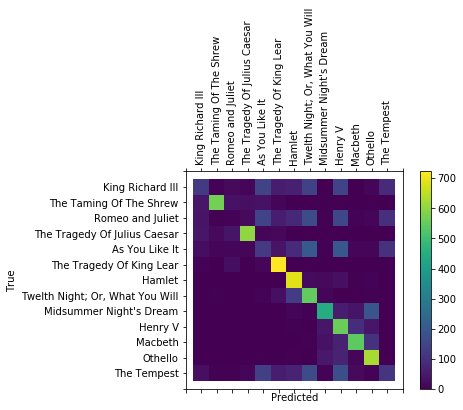

In [12]:
def print_cm(cm): 
    labels = encoder.classes_.tolist()
    labels_text = [id_to_text[id] for id in labels]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('')
    fig.colorbar(cax)
    plt.xticks(np.arange(-1, 13.5))
    plt.yticks(np.arange(-1, 13.5))
    ax.set_xticklabels([''] + labels_text, rotation='vertical')
    ax.set_yticklabels([''] + labels_text)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
print_cm(cm)

We see that some plays, like `King Richard III` cannot be distinguished, wheras `As You Like It` and `The Tragedy Of King Lear` can be distinguished very well. Let us also print the accuracy:

In [23]:
print("Accuracy: {}".format(np.sum(cm.diagonal()) / np.sum(cm)))

Accuracy: 0.8441


We need to do the same for the train generator since the generated data set comes from random seeds.

In [28]:
generator = batch_gen(batch_size=10000, seq_size=200, train_cv='train')
x, y = next(generator)
y_classes = encoder.inverse_transform(y)

preds = model.predict_classes(x)

preds_one_hot = np.zeros((preds.shape[0], 13))
for row, pred_class in enumerate(preds):
    preds_one_hot[row, pred_class] = 1

preds = encoder.inverse_transform(preds_one_hot)

cm = sklearn.metrics.confusion_matrix(y_classes, preds, labels=encoder.classes_)

10000/10000 [==============================] - 11s 1ms/step


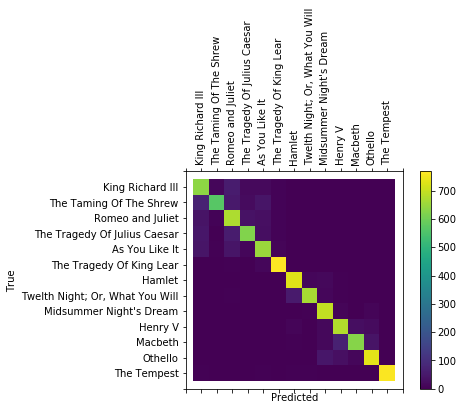

In [29]:
print_cm(cm)

In [30]:
print("Accuracy: {}".format(np.sum(cm.diagonal()) / np.sum(cm)))

Accuracy: 0.8819


## Generated data

Next, we evaluate the discriminator on the generated data. We first read the texts.

In [31]:
import os
generated_ids = ['1103', '1107', '1112', '1120', '1121', '1128', '1524', '1526', '2242', '2253', '2264', '2267', '23042']
generated_files = ['gen_data/' + id +'.txt' for id in generated_ids]

def read_txt(id):
    file_path = 'gen_data/gen_' + id + '.txt'
    with open(file_path) as f:
        return f.read()

all_generated_texts = {id: read_txt(id) for id in generated_ids}

Next, we write a batch generator. This is very similar to the one written for the training data, except that we do not  need to split between training and cross validation.

In [32]:
def batch_gen_generated(batch_size, seq_size=200):
    """
    Batch generator for evaluation the generated texts.
    
    :param batch_size: number of batches
    :param seq_size: number of characters per sequence
    """
    while True:
        # Get texts at random
        sampled_ids = np.random.choice(generated_ids, size=batch_size, replace=True)
        sampled_labels = encoder.transform(sampled_ids)

        # Get random starting points from each text
        text_lens = list(map(lambda x: len(all_generated_texts[x]), sampled_ids))
        start_indices = list(map(lambda x: np.random.choice(x), text_lens))

        # Generate random text sequences
        sequences = []
        for text_id, start_ind in zip(sampled_ids, start_indices):
            text_sequence = all_texts[text_id].text[start_ind:(start_ind+seq_size)]
            int_sequence = [vocab_to_int[s] for s in text_sequence]
            sequences.append(int_sequence)

        # Return
        yield np.array(sequences), np.array(sampled_labels)

Next, we calculate the confusion matrix. This also follows the same steps as before.

In [33]:
generator = batch_gen_generated(batch_size=10000, seq_size=200)
x, y = next(generator)
y_classes = encoder.inverse_transform(y)

preds = model.predict_classes(x)

preds_one_hot = np.zeros((preds.shape[0], 13))
for row, pred_class in enumerate(preds):
    preds_one_hot[row, pred_class] = 1

preds = encoder.inverse_transform(preds_one_hot)

cm = sklearn.metrics.confusion_matrix(y_classes, preds, labels=encoder.classes_)

10000/10000 [==============================] - 11s 1ms/step


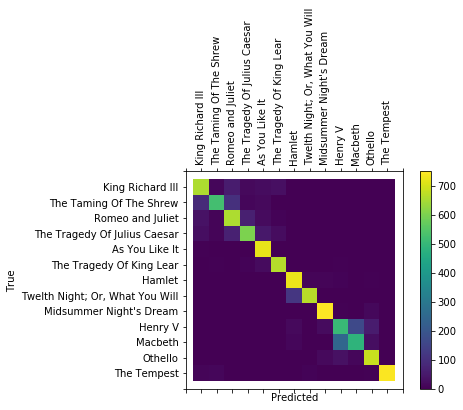

In [34]:
print_cm(cm)

The graph above shows the confusion matrix. 

Let us also show the accuracy:

In [35]:
print("Accuracy: {}".format(np.sum(cm.diagonal()) / np.sum(cm)))

Accuracy: 0.8418


## Conclusion

We conclude that the generated text can be discriminated almost as well as the original text. This gives a first hint that the text generation works. Of course, one can go much deeper with this analysis. Possible further explorations:

1. Why does the discriminator work? If it works only because of the names, for example, then we should try to remove them somehow. For example, we explicitly delete them before training and using the discriminator, or we use more advanced techniques like for example the technique that was presented in one of the papers: we would train a discriminator that is punished for using the character names. Otherwise, it is possible that the discriminator just remembers the names.
2. Use Generative adverserial networks for text generation: this is a different technique that allows one to generate texts. It would be interesting to evalualte whether it works better or worse.
3. Can we improve the context understanding of the generator either by training on larger sequence lengths and or adding more layers.
